Importing pandas and numpy

In [1]:
import pandas as pd
import numpy as np

Loading training set into dataframe called df

In [2]:
df = pd.read_csv('../data/raw/train.csv',low_memory=False)

In [3]:
df['ht'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 56091 entries, 0 to 56090
Series name: ht
Non-Null Count  Dtype 
--------------  ----- 
56011 non-null  object
dtypes: object(1)
memory usage: 438.3+ KB


converting height to cm

In [4]:
# height in centimeters
def feet_inches_to_cm(height):
    if isinstance(height, str):  
        parts = height.split('-')
        if len(parts) == 2 and parts[0].isdigit() and parts[1].isdigit():
            feet = int(parts[0])
            inches = int(parts[1])
        else:
            try:
                feet = int(parts[0])
                inches = 0
            except ValueError:
                return None  # for missing values
        total_inches = feet * 12 + inches
        cm = total_inches * 2.54
        return float(cm)
    return None  

In [5]:

df['ht_cm'] = df['ht'].apply(feet_inches_to_cm)

In [6]:
df['ht_cm'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 56091 entries, 0 to 56090
Series name: ht_cm
Non-Null Count  Dtype  
--------------  -----  
52090 non-null  float64
dtypes: float64(1)
memory usage: 438.3 KB


Removing nulls

In [7]:
df=df.dropna()

Splitting data into features and target

In [8]:
features = df.drop(['player_id','drafted','ht'],axis=1)
target = df['drafted']

One-hot-encoding

In [9]:
features = pd.get_dummies(features)

In [10]:
print(features.shape,target.shape)

(969, 232) (969,)


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

Training the model

In [15]:
from xgboost import XGBClassifier

grid search for best parameters

In [16]:
best_auc = 0
best_gamma = None
best_alpha = None
gamma_values = [0, 0.001, 0.01, 0.1, 1, 10]
alpha_values = [0, 0.001, 0.01, 0.1, 1, 10]

In [17]:
from sklearn.metrics import roc_auc_score

In [18]:
for gamma in gamma_values:
    for alpha in alpha_values:
        # Model training with regularization (XGBoost)
        xgb = XGBClassifier(gamma=gamma, alpha=alpha)
        xgb.fit(X_train_scaled, y_train)
        
        # Model evaluation with regularization (XGBoost)
        y_pred_prob = xgb.predict_proba(X_val_scaled)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_prob)
        
        if roc_auc > best_auc:
            best_auc = roc_auc
            best_gamma = gamma
            best_alpha = alpha

Training final model with best parameters

In [19]:
final_xgb = XGBClassifier(gamma=best_gamma, alpha=best_alpha)
final_xgb.fit(X_train_scaled, y_train)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [20]:
# Model evaluation (XGBoost)
y_pred_prob = final_xgb.predict_proba(X_val_scaled)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f'XGBoost AUROC: {roc_auc:.4f}')

XGBoost AUROC: 0.8340


In [21]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

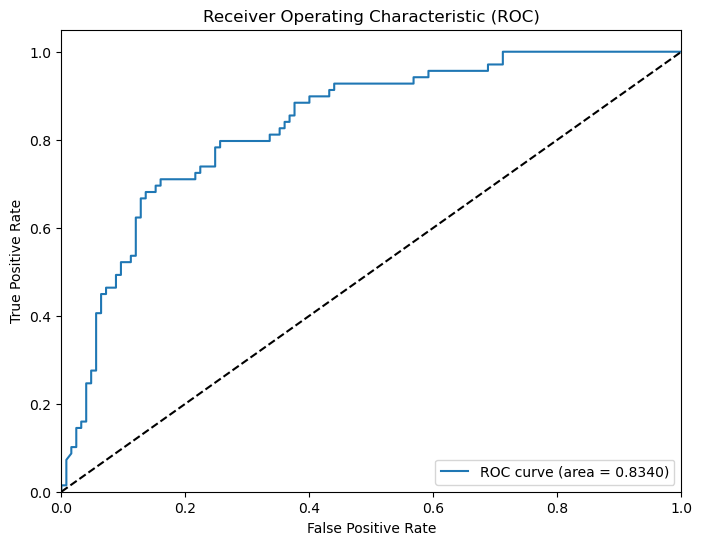

In [22]:
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [26]:
test_data = pd.read_csv('../data/raw/test.csv',low_memory=False)

In [27]:
test_data_processed = pd.get_dummies(test_data)
test_data_processed = test_data_processed.reindex(columns=features.columns, fill_value=0)  # Align columns
test_data_scaled = scaler.transform(test_data_processed)
predictions = final_xgb.predict_proba(test_data_scaled)[:,1]

In [28]:
test_data['drafted'] = predictions
print(test_data[['player_id', 'drafted']])

                                 player_id   drafted
0     cf302b4d-84f7-4124-a25d-a75eed31978b  0.479234
1     f91837cd-4f49-4b70-963d-aeb82c6ce3da  0.479234
2     53ec2a29-1e7d-4c6d-86d7-d60d02af8916  0.648403
3     32402798-471c-4a54-8cb4-29cd95199014  0.479234
4     73b960f9-27b8-4431-9d23-a760e9bbc360  0.512828
...                                    ...       ...
4965  a25ee55f-02a3-4f8e-8194-a5f427e14e7c  0.190426
4966  d0d9f45e-7b01-44b3-8d40-514ec338611d  0.071424
4967  f8df22c4-1602-4fab-896d-8820951aae2f  0.061995
4968  b791c69a-f769-4163-afda-051a6fd20a9d  0.061995
4969  18b51f5d-4746-4121-88fd-c8d0a1399130  0.061995

[4970 rows x 2 columns]


In [29]:
test_data[['player_id', 'drafted']].to_csv('predictions_xgb_refined_params.csv',index=False)

In [30]:
import joblib

In [31]:
filepath = "C:/Users/anika/AMLA/AT1/src/models/feet_inches_to_cm.joblib"

In [32]:
joblib.dump(feet_inches_to_cm, filepath)

['C:/Users/anika/AMLA/AT1/src/models/feet_inches_to_cm.joblib']